In [1]:
#iv_curve_analysis_testing.ipynb

"""
This notebook is designed to help us unpack and examine our first set of iv curve data
"""

import matplotlib.pyplot as plt
import numpy as np
import ali_offline_demod as dm
import glob as gl
from scipy import signal
import imp

imp.reload(dm)

/tmp/ipykernel_780124/757501663.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'ali_offline_demod' from '/home/matt/readout/host/ali_offline_demod.py'>

In [2]:
ts_file = 'ts_toneinit_fcenter_4250.0_20240202151540_t_20240202174221.hd5'
initial_lo_sweep='lo_sweep_initial_fcenter_4250.0_20240202151548.npy' #find initial lo sweep file
targeted_lo_sweep='lo_sweep_targeted_2_fcenter_4250.0_20240202151816.npy' #find targeted sweep file
tone_freqs='freq_list_lo_sweep_targeted_1_fcenter_4250.0_20240202151703.npy' #find tone freqs

init_freq = ts_file.split('_')[3]
init_time = ts_file.split('_')[4]

p = f'/home/matt/alicpt_data/tone_initializations/fcenter_{init_freq}_{init_time}/'

#print(gl.glob(p+'*'))

#print(p+'%s_*'%'lo_sweep')

print(gl.glob(p+'%s_*'%'lo_sweep_initial'))

#initial_lo_sweep = dm.find_file(f'/home/matt/alicpt_data/tone_initializations/fcenter_{init_freq}_{init_time}', 'lo_sweep_initial')
#print(initial_lo_sweep)


initial_lo_sweep = dm.find_file(p,'lo_sweep_initial')

print(initial_lo_sweep)

['/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240202151540/lo_sweep_initial_fcenter_4250.0_20240202151548.npy']
/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240202151540/lo_sweep_initial_fcenter_4250.0_20240202151548.npy


In [2]:
#1. Need to package the entire demod process as a single master function

def full_demod_process(ts_file, f_sawtooth, tone_init_path = '/home/matt/alicpt_data/tone_initializations', ts_path = '/home/matt/alicpt_data/time_streams'):
    #unpack data -> eventually change so that you give the ts data path and the function finds the associated tone initialization files
    
    init_freq = ts_file.split('_')[3]
    init_time = ts_file.split('_')[4]    
    init_directory = f'{tone_init_path}/fcenter_{init_freq}_{init_time}/'
    
    initial_lo_sweep_path = dm.find_file(init_directory, 'lo_sweep_initial')
    targeted_lo_sweep_path = dm.find_file(init_directory, 'lo_sweep_targeted_2')
    tone_freqs_path = dm.find_file(init_directory, 'freq_list_lo_sweep_targeted_1')
    ts_path = f'{ts_path}/{ts_file}'    
    
    initial_lo_sweep=np.load(initial_lo_sweep_path) #find initial lo sweep file
    targeted_lo_sweep=np.load(targeted_lo_sweep_path) #find targeted sweep file
    tone_freqs=np.load(tone_freqs_path) #find tone freqs
    ts_fr,Is_fr,Qs_fr=dm.read_data(ts_path)    
    
    #look at initial sweep
    dm.plot_s21([initial_lo_sweep])
    
    #choose delay region - should automate finding an area without peaks later
    delay_region_start = float(input('Delay Region Start (GHz): '))*1e9
    delay_region_stop = float(input('Delay Region Stop (GHz): '))*1e9
    
    #measure cable delay
    delays = dm.measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=False)
    
    #remove cable delay
    targeted_lo_sweep_rm=dm.remove_delay(targeted_lo_sweep,np.median(delays))
    IQ_stream_rm=dm.remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))
    
    #measure circle parameters
    calibration=dm.measure_circle_allch(targeted_lo_sweep_rm,tone_freqs) #finds circle center and initial phase for every channel
    
    #calibrate time stream
    data_cal=dm.get_phase(IQ_stream_rm,calibration)
    
    #find nphi_0
    t_start=20
    t_stop=30

    n_phi0 = dm.find_n_phi0(ts_fr[488*t_start:488*t_stop],data_cal[:,488*t_start:488*t_stop],f_sawtooth,plot=False)  #discard the first few seconds
    
    #find t0
    t0_array = np.array([])
    for current_channel in range(len(data_cal)):
        t0 = dm.mea_reset_t0(ts_fr[488*t_start:488*t_stop],data_cal[current_channel,488*t_start:488*t_stop],f_sawtooth,plot=False)
        t0_array = np.append(t0_array,t0)

    t0_med = np.nanmedian(t0_array)
    
    #demod
    
    t_demods=[]
    data_demods=[]
    start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
    for chan in range(data_cal.shape[0]):#np.arange(225,230,1):#range(data_cal.shape[0]):
        t_demod, data_demod = dm.demodulate(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[chan, start_idx:], n_phi0, f_sawtooth, plot = False, plot_len = None)
        t_demods.append(t_demod)
        data_demod_unwrap=np.unwrap(data_demod,period=1)
        data_demods.append(data_demod_unwrap)

    data_demods=np.vstack(data_demods)
    t_demods=np.vstack(t_demods)
    
    data_dict = {'fr t': ts_fr, 'nphi': n_phi0, 't0': t0_med, 'demod t': t_demods[1], 'demod data': data_demods, 'channel freqs': tone_freqs, 'fsawtooth': f_sawtooth}
    
    return data_dict

def get_mean_current(bias_info,times,data):
    """
    get the mean of Ites for all channels based on bias values and times
    time is unix time
    data is the output dm.demodulate, in unit of phi0 numbers
    """
    data_bin=np.zeros((data.shape[0],bias_info.shape[0]))
    print (data_bin.shape)
    for j in range(data.shape[0]):
        data_ch=data[j]
        for i in range(bias_info.shape[0]):
            bs_time=bias_info[i,0]
            chunck=data_ch[np.where((times>bs_time+0.4)&(times<bs_time+1.6))]
            data_bin[j,i]=np.mean(chunck)
    data_bin=np.apply_along_axis(unwrap_change_current_per_chan, 1, data_bin)       
    return data_bin    

def unwrap_change_current_per_chan(data_ch):
    data_ch_unwrap=np.unwrap(data_ch,discont=0.48,period=1)
    data_ch_uA=data_ch_unwrap*9
    return data_ch_uA

def IV_analysis_ch_new(bias_currents,resps,Rsh=0.4,plot=None):
    """
    This method completely abandon the part that Ites might vary larger than 0.5 phi0 given the step limit of the Ibias
    i.e. it only cares about the Al normal state and part of Al transition state
    it assumes Rn_almn is 7.25mohm
    Outputs:
    dataframe containing timestream of Ites,Rtes,Vtes,Rn_almn,Rn_al
    """
    #only getting Al TES normal point
    Rn_almn=7.25
    peaks_nb,_=signal.find_peaks(0-resps,width=20)
    if len(peaks_nb)==0:
        return
    peak_nb=peaks_nb[0]
    resps_nb=resps[2:int(peak_nb-10)]
    bias_nb=bias_currents[2:peak_nb-10]
    r_ratio_al,shift = np.polyfit(bias_nb, resps_nb, 1)
    Rn_al=Rsh/r_ratio_al-Rsh*1e-3-Rn_almn*1e-3  #Ohm
    #print ('normal resistance for al TES',Rn_al)
    Ites=resps-shift #uA
    Ishunt=bias_currents*1e-3-Ites*1e-6 #A
    Vshunt=Ishunt*Rsh*1e-3 #V
    Rtes=Vshunt/(Ites*1e-6)-Rn_almn*1e-3 #Ohm
    bps=Rtes/Rn_al
    Vtes=Rtes*Ites#uV
    if Rn_al>0.05 or Rn_al<0.005: return
    if plot=='IV':
        plt.gcf().subplots_adjust(bottom=0.2)
        plt.gcf().subplots_adjust(left=0.2)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.plot(Vtes,Ites,alpha=0.8)
        plt.xlabel('$V_{tes}$ (μV)',fontsize=18)
        plt.ylabel('$I_{tes}$ (μA)',fontsize=18)
    if plot=='bp':
        plt.gcf().subplots_adjust(bottom=0.2)
        plt.gcf().subplots_adjust(left=0.2)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.plot(bias_currents,bps*100,alpha=0.3)
        plt.ylim(0,1.2*100)
        plt.ylabel('$\%R_n$',fontsize=18)
        plt.xlabel(r'$I_{bias}$',fontsize=18)
    return Rn_al,Rtes,Vtes,Ites,bps

    
def full_IV_process(iv_file,f_sawtooth,Rsh=0.4,iv_path = '/home/matt/alicpt_data/IV_data', plot=None):
    """
    wrapper examining all IV curves from a dataset
    """
    #only getting Al TES normal point
    
    bias_currents_path = dm.find_file(f'{iv_path}/{iv_file}/', 'bias_data')
    bias_currents = np.loadtxt(bias_currents_path)    
    
    ts_path = dm.find_file(f'{iv_path}/{iv_file}/', 'ts')
    ts_directory = ts_path.split('/')[-2]
    ts_filename = ts_path.split('/')[-1]
    
    
    demod_data = full_demod_process(ts_filename, f_sawtooth, ts_path = f'/home/matt/alicpt_data/IV_data/{ts_directory}')
    start_idx = dm.find_nearest_idx(demod_data['fr t']-demod_data['fr t'][0], demod_data['t0'])
    
    data_demods_bin = get_mean_current(bias_currents,demod_data['demod t']+demod_data['fr t'][start_idx],demod_data['demod data'])
    
    Rn_al = []
    Rtes = []
    Vtes = []
    Ites = []
    bps = []
    for ch in range(data_demods_bin.shape[0]):
        try:
            Rn_al_ch,Rtes_ch,Vtes_ch,Ites_ch,bps_ch = IV_analysis_ch_new(bias_currents[:,1],data_demods_bin[ch],plot=None)
        except:
            Rn_al_ch = np.nan
            Rtes_ch = np.ones(len(bias_currents[:,1]))*np.nan
            Vtes_ch = np.ones(len(bias_currents[:,1]))*np.nan
            Ites_ch = np.ones(len(bias_currents[:,1]))*np.nan
            bps_ch = np.ones(len(bias_currents[:,1]))*np.nan            
            continue
        
        Rn_al.append(Rn_al_ch)
        Rtes.append(Rtes_ch)
        Vtes.append(Vtes_ch)
        Ites.append(Ites_ch)
        bps.append(bps_ch)
        
    #Rn_al = np.vstack(Rn_al)
    Rtes = np.vstack(Rtes)
    Vtes = np.vstack(Vtes)
    Ites = np.vstack(Ites)
    bps = np.vstack(bps)
    
    data_dict = {'Ibias': bias_currents[:,1], 
                 'Rn Al': Rn_al,
                 'Rtes': Rtes,
                 'Vtes': Vtes,
                 'Ites': Ites,
                 'bps': bps}
       
    return data_dict

def get_Ibias_bp(bias_currents,resps,bp):
    #get Ibias when giving bias point
    Rn_al,Rtes,Vtes,Ites,bps=IV_analysis_ch_new(bias_currents,resps,Rsh=0.4,plot=None)
    if Rn_al>0.05 or Rn_al<0.005:
        return 
    else:
        turn_point,_= signal.find_peaks(0-bps,width=10)
        print ('turn_point',turn_point[-1])
        #print ('turning point'+turn_point[-1])
        Ibias_low=bias_currents[turn_point[-1]]
        bps_sel=bps[np.where(bias_currents>Ibias_low)]
        bias_currents_sel=bias_currents[np.where(bias_currents>Ibias_low)]
        idx=dm.find_nearest_idx(bps_sel,bp)
        print (idx)
        Ibias_bp = bias_currents_sel[idx]
        print (Ibias_bp)
        plt.gcf().subplots_adjust(bottom=0.2)
        plt.gcf().subplots_adjust(left=0.2)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.plot(bias_currents,bps*100)
        plt.vlines(Ibias_bp,0,120)
        plt.xlabel('$I_{bias}$ (mA)',fontsize=18)
        plt.ylabel('$\%(R_n)$',fontsize=18)
        plt.ylim(0,120)
        return Ibias_bp

def analyze_bp(Ibias, data_demods_bin, ch):
    computed_bias_pt = np.array([])
    for ch in range(data_demods_bin.shape[0]):
        try:
            computed_bias_pt = np.append(computed_bias_pt, get_Ibias_bp(Ibias[:,1],data_demods_bin[ch],0.5))
        except:
            continue
        
    median_bp = np.median(computed_bias_pt)
    
    return

"""
def iv_analyze():
    data_demods_bin = get_mean_current(Ibias,t_demod+ts_fr[start_idx],data_demods)

    for ch in range(data_demods_bin.shape[0]):
        try:
            IV_analysis_ch_new(Ibias[:,1],data_demods_bin[ch],plot='IV')

        except:
            continue
"""

/home/matt/readout/host/ali_offline_demod.py:506: RuntimeWarning: divide by zero encountered in log10
  mag = 20* np.log10(np.abs(sweep_Z))
/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


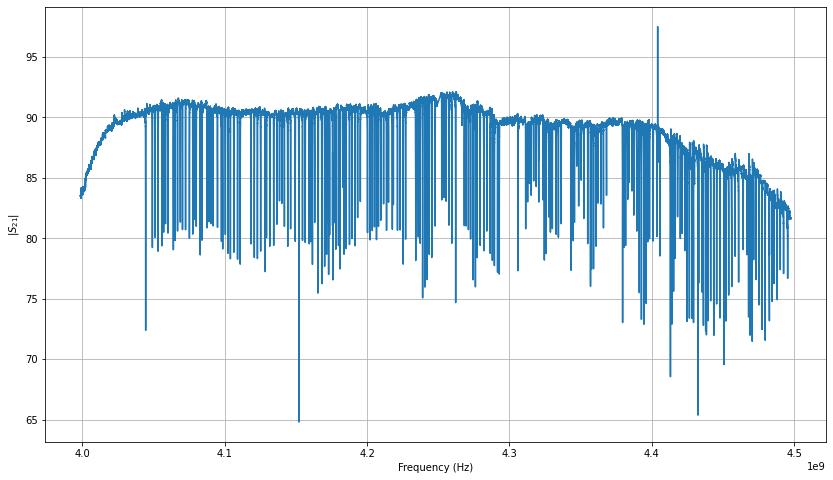

Delay Region Start (GHz):  4.02
Delay Region Stop (GHz):  4.03


3.372806407385219


/home/matt/.local/readout/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matt/.local/readout/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(233, 188)


In [3]:
iv_file = 'toneinit_fcenter_4250.0_20240202151540_t_20240202155930'


result = full_IV_process(iv_file,f_sawtooth=5,Rsh=0.4,iv_path = '/home/matt/alicpt_data/IV_data', plot=None)

In [11]:
result['Rn Al']

[0.012561353316284267,
 0.012732544325348476,
 0.013024440360002557,
 0.013550730637887726,
 0.01229039497160183,
 0.012214572139123664,
 0.013101842456942736,
 0.01254097116256439,
 0.012113860130067926,
 0.012258628098765066,
 0.01208932500817916,
 0.012497824730347874,
 0.01263833035979426,
 0.010251050271446342,
 0.012665408991220189,
 0.013242610561957854,
 0.02604664170962903,
 0.012126967941684275,
 0.012177205238566819,
 0.012380509612942004,
 0.012568877695472973,
 0.0124882110551073,
 0.012729863256525278,
 0.012585790119727089,
 0.012330304992091399,
 0.012308210989414075,
 0.012409795117119465,
 0.012882112106854696,
 0.012071587881109472,
 0.012405382060727017,
 0.01253059103363471,
 0.013219235058764978,
 0.012764597635062803,
 0.0124675487782407,
 0.012550337698095299,
 0.013458210422788146,
 0.013456762207662409,
 0.013261152177657519,
 0.01239708752921577,
 0.012384203169690664,
 0.01316757150216985,
 0.012974773503963491,
 0.013545035180520092,
 0.013544916985309408,


(0.0, 2.0)

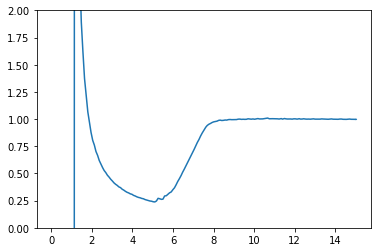

In [9]:
channel = 30

plt.plot(result['Ibias'],result['bps'][channel])
plt.ylim([0,2])

#print(result['Ites'])

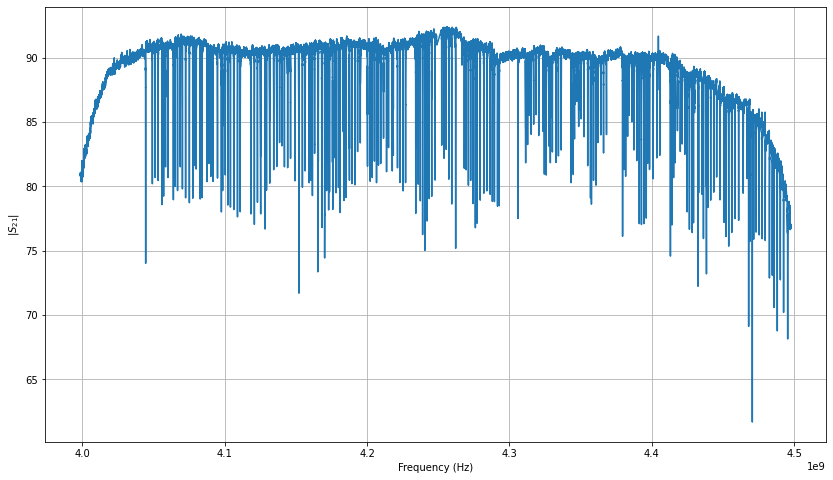

Delay Region Start (GHz):  4.02
Delay Region Stop (GHz):  4.03


/home/matt/.local/readout/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matt/.local/readout/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10240
20.969720602035522
104
0
0.0984184741973877
1
0.2991952896118164
2
0.49767637252807617
3
0.6984131336212158
4
0.8992352485656738
5
1.097717523574829
6
1.2985990047454834
7
1.4993562698364258
8
1.698150634765625
9
1.8986594676971436
10
2.0992307662963867
11
2.297961711883545
12
2.4989497661590576
13
2.699235677719116
14
2.8980393409729004
15
3.098712921142578
16
3.299501657485962
17
3.4983015060424805
18
3.698842763900757
19
3.899470806121826
20
4.098214626312256
21
4.298880577087402
22
4.49962854385376
23
4.698215007781982
24
4.898901462554932
25
5.099599838256836
26
5.298384428024292
27
5.499063968658447
28
5.699922323226929
29
5.898395776748657
30
6.099024534225464
31
6.2997870445251465
32
6.4984564781188965
33
6.699158668518066
34
6.90004301071167
35
7.0986621379852295
36
7.29915976524353
37
7.49993896484375
38
7.698615789413452
39
7.899487733840942
40
8.100194454193115
41
8.298645257949829
42
8.499510049819946
43
8.700225591659546
44
8.898930788040161
45
9.09946870803833
46
9

In [12]:
init_path = '/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240202151540/'
tspath = '/home/matt/alicpt_data/time_streams/'

initial_lo_sweep='lo_sweep_initial_fcenter_4250.0_20240202151548.npy' #find initial lo sweep file
targeted_lo_sweep='lo_sweep_targeted_2_fcenter_4250.0_20240202151816.npy' #find targeted sweep file
tone_freqs='freq_list_lo_sweep_targeted_1_fcenter_4250.0_20240202151703.npy' #find tone freqs
ts='ts_toneinit_fcenter_4250.0_20240202151540_t_20240202174221.hd5' #no chop 7

result = full_demod_process('ts_toneinit_fcenter_4250.0_20240202104043_t_20240202122854.hd5',f_sawtooth=5)

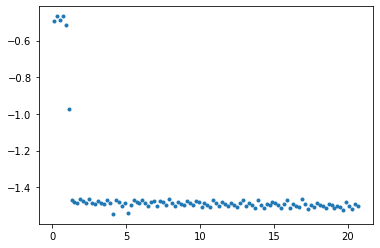

In [20]:
channel = 6

#print(result['demod data'][0:10])

plt.plot(result['t'],result['demod data'][channel],'.')

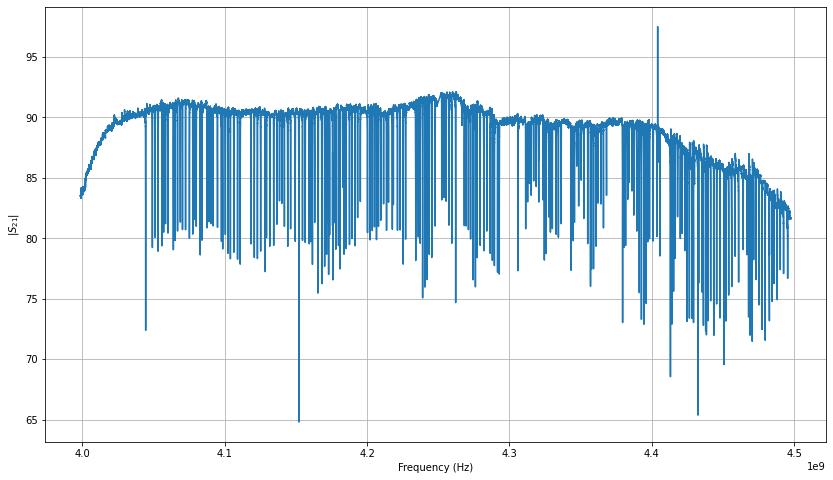

Delay Region Start (GHz):  4.02
Delay Region Stop (GHz):  4.03


(233, 188)
[[  -7.39005947   -7.24121706   -7.24233671 ...   -7.356898
    -8.09655587   -7.40511937]
 [  70.14265991   70.1642773    68.9752092  ... -218.7729995
  -222.79582615 -227.24010144]
 [  60.39432692   60.42950645   58.76173763 ... -271.79766802
  -275.64912706 -271.18138897]
 ...
 [  -2.25431196   -2.21501422   -2.22594285 ...   -2.33242044
    -2.34187062   -2.31685256]
 [  -2.84409304   -2.73339828   -2.76116422 ...   -3.00961344
    -3.00949889   -3.04776741]
 [  -1.30934918   -1.32242249   -1.24263485 ...   -1.36413705
    -1.60951116   -1.60298386]]


ValueError: `x` must be a 1-D array

In [7]:
Rn_al,Rtes,Vtes,Ites,bps = IV_analysis('toneinit_fcenter_4250.0_20240202151540_t_20240202155930',f_sawtooth=5,Rsh=0.4, plot=None)

In [22]:
a = [1,2,3,4]
b = [[4,5,6],[7,8,9]]

data = {'a_data':a,'b_data':b}

print(data['b_data'])

[[4, 5, 6], [7, 8, 9]]


In [ ]:


data_demods_bin = get_mean_current(Ibias,t_demod+ts_fr[start_idx],data_demods)

for ch in range(data_demods_bin.shape[0]):
    try:
        IV_analysis_ch_new(Ibias[:,1],data_demods_bin[ch],plot='IV')
        
    except:
        continue

In [13]:
a = [1,2,np.nan]


In [14]:
print(a)

[1, 2, nan]
